# 13.10. 转置卷积

到目前为止，我们所见到的卷积神经网络层，例如卷积层（ 6.2节）和汇聚层（ 6.5节），通常会减少下采样输入图像的空间维度（高和宽）。 然而如果输入和输出图像的空间维度相同，在以像素级分类的语义分割中将会很方便。 例如，输出像素所处的通道维可以保有输入像素在同一位置上的分类结果。

为了实现这一点，尤其是在空间维度被卷积神经网络层缩小后，我们可以使用另一种类型的卷积神经网络层，它可以增加上采样中间层特征图的空间维度。 本节将介绍 转置卷积（transposed convolution） ([Dumoulin and Visin, 2016](https://zh-v2.d2l.ai/chapter_references/zreferences.html#id37))， 用于逆转下采样导致的空间尺寸减小。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 13.10.1. 基本操作
让我们暂时忽略通道，从基本的转置卷积开始，设步幅为1且没有填充。 假设我们有一个$n_h \times n_w$的输入张量和一个$k_h \times k_w$的卷积核。 以步幅为1滑动卷积核窗口，每行$n_w$次，每列$n_h$次，共产生$n_hn_w$个中间结果。 每个中间结果都是一个$(n_h + k_h -1)\times (n_w + k_w -1)$
的张量，初始化为0。 为了计算每个中间张量，输入张量中的每个元素都要乘以卷积核，从而使所得的$k_hk_w$张量替换中间张量的一部分。 请注意，每个中间张量被替换部分的位置与输入张量中元素的位置相对应。 最后，所有中间结果相加以获得最终结果。

例如， 图13.10.1解释了如何为$2 \times 2$的输入张量计算卷积核为$2 \times 2$的转置卷积。

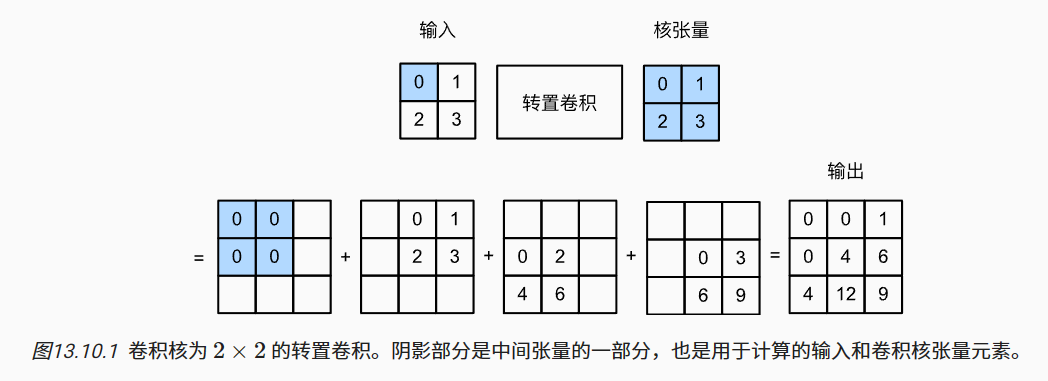

我们可以对输入矩阵X和卷积核矩阵K实现基本的转置卷积运算trans_conv。

In [2]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

与通过卷积核“减少”输入元素的常规卷积（在 6.2节中）相比，转置卷积通过卷积核“广播”输入元素，从而产生大于输入的输出。 我们可以通过 图13.10.1来构建输入张量X和卷积核张量K从而验证上述实现输出。 此实现是基本的二维转置卷积运算。

In [3]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

或者，当输入X和卷积核K都是四维张量时，我们可以使用高级API获得相同的结果。

In [4]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<SlowConvTranspose2DBackward>)

## 13.10.2. 填充、步幅和多通道
与常规卷积不同，在转置卷积中，填充被应用于的输出（常规卷积将填充应用于输入）。 例如，当将高和宽两侧的填充数指定为1时，转置卷积的输出中将删除第一和最后的行与列。

In [5]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<SlowConvTranspose2DBackward>)

在转置卷积中，步幅被指定为中间结果（输出），而不是输入。 使用 图13.10.1中相同输入和卷积核张量，将步幅从1更改为2会增加中间张量的高和权重，因此输出张量在 图13.10.2中。



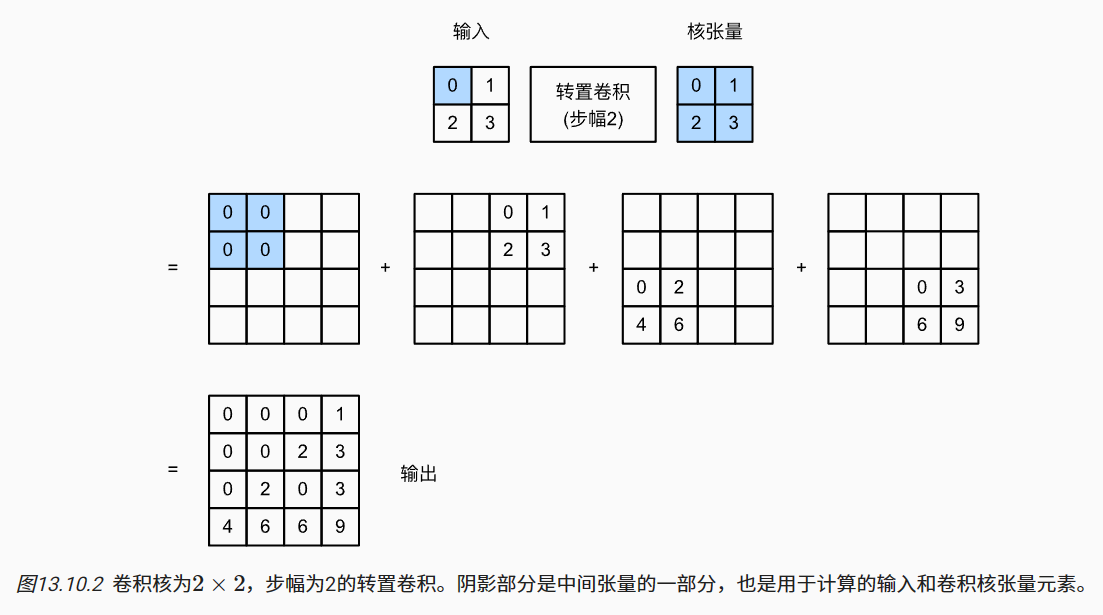

以下代码可以验证 图13.10.2中步幅为2的转置卷积的输出。

In [6]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<SlowConvTranspose2DBackward>)

对于多个输入和输出通道，转置卷积与常规卷积以相同方式运作。 假设输入有$c_i$个通道，且转置卷积为每个输入通道分配了一个$k_h \times k_w$的卷积核张量。 当指定多个输出通道时，每个输出通道将有一个$c_i \times k_h \times k_w$的卷积核。

同样，如果我们将$X$代入卷积层$f$来输出$Y=f(X)$，并创建一个与$f$具有相同的超参数、但输出通道数量是$X$中通道数的转置卷积层$g$，那么$g(Y)$的形状将与$X$相同。 下面的示例可以解释这一点。

In [7]:
X = torch.rand(size=(1,10,16,16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

True

## 13.10.3. 与矩阵变换的联系
转置卷积为何以矩阵变换命名呢？ 让我们首先看看如何使用矩阵乘法来实现卷积。 在下面的示例中，我们定义了一个$3 \times 3$的输入X和$2  \times 2$卷积核K，然后使用corr2d函数计算卷积输出Y。

In [12]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
print(Y)
print(X)

tensor([[27., 37.],
        [57., 67.]])
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


接下来，我们将卷积核K重写为包含大量0的稀疏权重矩阵W。 权重矩阵的形状是（$4$，$9$），其中非0元素来自卷积核K。

In [13]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

逐行连结输入X，获得了一个长度为9的矢量。 然后，W的矩阵乘法和向量化的X给出了一个长度为4的向量。 重塑它之后，可以获得与上面的原始卷积操作所得相同的结果Y：我们刚刚使用矩阵乘法实现了卷积。

In [14]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[True, True],
        [True, True]])

同样，我们可以使用矩阵乘法来实现转置卷积。 在下面的示例中，我们将上面的常规卷积$2 \times 2$的输出Y作为转置卷积的输入。 想要通过矩阵相乘来实现它，我们只需要将权重矩阵W的形状转置为$(9,4)$。

In [15]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)
print(Z)

tensor([[ 27.,  91.,  74.],
        [138., 400., 282.],
        [171., 429., 268.]])


抽象来看，给定输入向量$\mathbf{x}$和权重矩阵$\mathbf{W}$，卷积的前向传播函数可以通过将其输入与权重矩阵相乘并输出向量$\mathbf{y = Wx}$
来实现。 由于反向传播遵循链式法则和$\mathbf{\nabla_xy=W^T}$，卷积的反向传播函数可以通过将其输入与转置的权重矩阵$\mathbf{W^T}$相乘来实现。 因此，转置卷积层能够交换卷积层的正向传播函数和反向传播函数：它的正向传播和反向传播函数将输入向量分别与$\mathbf{W^T}$和$\mathbf{W}$相乘。

## 13.10.4. 小结
- 与通过卷积核减少输入元素的常规卷积相反，转置卷积通过卷积核广播输入元素，从而产生形状大于输入的输出。
- 如果我们将$\mathbf{X}$输入卷积层$f$来获得输出$\mathbf{Y=f(X)}$并创造一个与$f$有相同的超参数、但输出通道数是$\mathbf{X}$中通道数的转置卷积层$g$，那么$g(\mathbf{Y})$的形状将与$\mathbf{X}$相同。
- 我们可以使用矩阵乘法来实现卷积。转置卷积层能够交换卷积层的正向传播函数和反向传播函数。

## 13.10.5. 练习
1. 在 13.10.3节中，卷积输入X和转置的卷积输出Z具有相同的形状。他们的数值也相同吗？为什么？
2. 使用矩阵乘法来实现卷积是否有效率？为什么？

回答：
1. 数值不相同，不可逆，形状相同。
2. 效率高。原因：
①普通卷积操作的前向传播通过矩阵乘法一次实现，而非形式上的卷积核进行卷积并平移
②普通卷积操作的反向传播是输入乘转置权重矩阵
③上述代码表明，转置卷积作用实质上也是矩阵乘法，其前向传播为普通卷积的反向传播，反向传播同理